# COMP47670 Assignment 1 - Task 2

Student ID: 24292215

Student Name: Lucas Sipos George

---

## Summary Assignment 1
The objective of this assignment is to collect a dataset from [**API Sports**](https://api-sports.io) about the players from different teams (Real Madrid, Manchester City, Paris Saint Germain, Bayern München) that play in UEFA Champions League and then use Python to prepare, analyse, and derive insights from the collected data individually and all together.

---

### Task 2

This notebook covers **Task 2 - Data Preparation and Analysis**. We will use all of the JSON data collected during Task 1 to perform the analysis process.



In [62]:
import json
from pathlib import Path
import pandas as pd
from typing import List
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import seaborn as sns

In [63]:
# the teams we have information on
FOOTBALL_TEAMS = ["Real Madrid", "Manchester City", "Paris Saint Germain", "Bayern München"]
# the league we pull the players' stats
FOOTBALL_LEAGUE = "UEFA Champions League"
# dictionary which assigns every team a color
FOOTBALL_TEAMS_COLORS = dict(zip(FOOTBALL_TEAMS, ["yellow", "deepskyblue", "red", "green"]))

Directories for data storage:

In [64]:
raw_data_directory = Path("raw")
data_directory = Path("data")
data_directory.mkdir(parents=True, exist_ok=True)

### Data Processing

Before we can analyse the data, we need to transform it into a usable format.

Firstly, find all of the raw JSON files and separate them by team:

In [65]:
team_files = {team: [] for team in FOOTBALL_TEAMS}
for file_path in raw_data_directory.iterdir():
    if file_path.is_dir():
        continue
    if file_path.suffix == ".json":
        # parse the file name
        details = file_path.stem.split("_")
        if details[0] in FOOTBALL_TEAMS:
            team_files[details[0]].append(file_path)
for team in FOOTBALL_TEAMS:
    print(f"{team}: Found {len(team_files[team])} raw files")

Real Madrid: Found 1 raw files
Manchester City: Found 1 raw files
Paris Saint Germain: Found 1 raw files
Bayern München: Found 1 raw files


### Data Parsing and Merging

We will define a function that will parse an individual raw JSON data file coming from the API Sports.

The nice part about this API is that the fetch we've done in Part 1 is very voluptuous in data per player.


In [66]:
def parse_raw_data(team_name: str, f_path: Path) -> pd.DataFrame:
    with open(f_path, "r") as f:
        json_data = f.read()
        data = json.loads(json_data)
    # handle each observation
    rows = []
    for player in data:
        row = {"Team": team_name}
        # add the id for uniqueness 
        row["ID"] = player["player"]["id"]
        # add player name
        row["Name"] = player["player"]["name"]
        # add player age
        row["Age"] = player["player"]["age"]
        # add player place of birth
        row["Birth_Country"] = player["player"]["birth"]["country"]
        # The height is given as a string in cm e.g.: "170 cm"
        row["Height_cm"] = int(player["player"]["height"].split(" ")[0]) if player["player"]["height"] else 0
        # The weight is given as a string in kg e.g.: "80 kg"
        row["Weight_kg"] = int(player["player"]["weight"].split(" ")[0]) if player["player"]["weight"] else 0
        # add player injured as a boolean
        row["Injured"] = player["player"]["injured"]
        # add number of cards the player got
        row["Cards_R"] = player["statistics"][0]["cards"]["red"]
        row["Cards_Y"] = player["statistics"][0]["cards"]["yellow"]
        row["Cards_YR"] = player["statistics"][0]["cards"]["yellowred"]
        # add number of dribbles the player has done
        row["Dribbles_Attempts"] = player["statistics"][0]["dribbles"]["attempts"]
        row["Dribbles_Success"] = player["statistics"][0]["dribbles"]["success"]
        # add number of duels the player had
        row["Duels_Total"] = player["statistics"][0]["duels"]["total"]
        row["Duels_Won"] = player["statistics"][0]["duels"]["won"]
        # add number of fouls the player has commited/drawn
        row["Fouls_Commited"] = player["statistics"][0]["fouls"]["committed"]
        row["Fouls_Drawn"] = player["statistics"][0]["fouls"]["drawn"]
        # add some overall games information on a player
        row["Games_Appearences"] = player["statistics"][0]["games"]["appearences"]
        row["Games_Lineups"] = player["statistics"][0]["games"]["lineups"]
        row["Games_Minutes"] = player["statistics"][0]["games"]["minutes"]
        row["Games_Position"] = player["statistics"][0]["games"]["position"]
        # transform every game rating to a float if exists else -1
        row["Games_Rating"] = float(player["statistics"][0]["games"]["rating"]) if player["statistics"][0]["games"][
            "rating"] else -1
        # add the number of goals 
        row["Goals_Assists"] = player["statistics"][0]["goals"]["assists"]
        row["Goals_Conceded"] = player["statistics"][0]["goals"]["conceded"]
        row["Goals_Saves"] = player["statistics"][0]["goals"]["saves"]
        row["Goals_Total"] = player["statistics"][0]["goals"]["total"]
        # add the number of passes
        row["Passes_Key"] = player["statistics"][0]["passes"]["key"]
        row["Passes_Total"] = player["statistics"][0]["passes"]["total"]
        # add number of penalties
        row["Penalty_Commited"] = player["statistics"][0]["penalty"]["commited"]
        row["Penalty_Missed"] = player["statistics"][0]["penalty"]["missed"]
        row["Penalty_Saved"] = player["statistics"][0]["penalty"]["saved"]
        row["Penalty_Scored"] = player["statistics"][0]["penalty"]["scored"]
        # add number of shots
        row["Shots_On"] = player["statistics"][0]["shots"]["on"]
        row["Shots_Total"] = player["statistics"][0]["shots"]["total"]
        # add number of substitutes
        row["Substitutes_Bench"] = player["statistics"][0]["substitutes"]["bench"]
        row["Substitutes_In"] = player["statistics"][0]["substitutes"]["in"]
        row["Substitutes_Out"] = player["statistics"][0]["substitutes"]["out"]
        # add number of tackles
        row["Tackles_Blocks"] = player["statistics"][0]["tackles"]["blocks"]
        row["Tackles_Interceptions"] = player["statistics"][0]["tackles"]["interceptions"]
        row["Tackles_Total"] = player["statistics"][0]["tackles"]["total"]
        rows.append(row)
    return pd.DataFrame(rows)

We will define a function that will parse and merge a collection of raw data files:

In [67]:
def parse_merge_raw_data(team_name: str, f_paths: List[Path]) -> pd.DataFrame:
    df_files = []
    print(f"Reading and parsing {len(f_paths)} JSON data files...")
    for f_path in f_paths:
        # produce a DataFrame from this file
        df_file = parse_raw_data(team_name, f_path)
        df_files.append(df_file)
    # concatenate all pandas receive in one
    df_team_data = pd.concat(df_files)
    # set index to unique ID
    df_team_data.set_index("ID", inplace=True)
    # return data sorted by the player's overall rating
    return df_team_data.sort_values(by=["Games_Rating"], ascending=False)

Parse and merge the raw data files for each team, producing a single merged Pandas Data Frames for each team which we can analyse later on:

In [68]:
df_teams = {}
for team in FOOTBALL_TEAMS:
    print(f"--- Processing {team} ---")
    df_team = parse_merge_raw_data(team, team_files[team])
    df_teams[team] = df_team

--- Processing Real Madrid ---
Reading and parsing 1 JSON data files...
--- Processing Manchester City ---
Reading and parsing 1 JSON data files...
--- Processing Paris Saint Germain ---
Reading and parsing 1 JSON data files...
--- Processing Bayern München ---
Reading and parsing 1 JSON data files...


### Data Verification

Filter the players that didn't play

In [69]:
# Take only the players that have done something
for team in FOOTBALL_TEAMS:
    print(f"Processing {team} – Before: {len(df_teams[team])} – ", end="")
    df_teams[team] = df_teams[team][df_teams[team]["Games_Appearences"] > 0]
    print(f"After: {len(df_teams[team])}")

Processing Real Madrid – Before: 20 – After: 16
Processing Manchester City – Before: 20 – After: 17
Processing Paris Saint Germain – Before: 20 – After: 11
Processing Bayern München – Before: 20 – After: 11


In [70]:
# if there are missing fields, these should only be int fields
for team in FOOTBALL_TEAMS:
    df_teams[team] = df_teams[team].fillna(0)

We check to see if we have any missing value in any of our DataFrames:

In [71]:
for team in FOOTBALL_TEAMS:
    print(f"--- {team} ---")
    missing_counts = df_teams[team].isnull().sum()
    # which columns have missing values?
    missing_counts = missing_counts[missing_counts > 0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

--- Real Madrid ---
No missing values found
--- Manchester City ---
No missing values found
--- Paris Saint Germain ---
No missing values found
--- Bayern München ---
No missing values found


Transform every column that needs to be an int into an int

In [72]:
# column that are not of type int
columns_to_exclude = ["Team", "Name", "Age", "Birth_Country", "Height_cm", "Weight_cm", "Injured", "Games_Position",
                      "Games_Rating"]
# get the column that are of type int
columns_remaining = list(df_teams[FOOTBALL_TEAMS[0]].columns.difference(columns_to_exclude))
for team in FOOTBALL_TEAMS:
    # change the type of the column
    df_teams[team][columns_remaining] = df_teams[team][columns_remaining].astype(int)

### Data Saving

Save the merged data with an appropriate name ("**_\<Team\>\_\<League\>.json_**") and the data directory as json.

In [73]:
for team in FOOTBALL_TEAMS:
    file_name = f"{team}_{FOOTBALL_LEAGUE}.json"
    out_path = data_directory / file_name
    print(f"Writing {out_path}")
    df_teams[team].to_json(out_path, indent=4)

Writing data/Real Madrid_UEFA Champions League.json
Writing data/Manchester City_UEFA Champions League.json
Writing data/Paris Saint Germain_UEFA Champions League.json
Writing data/Bayern München_UEFA Champions League.json


## Data Analysis

### Data Loading

We reload the data to see if we stored it correctly and skip previous steps if needed.

In [74]:
df_teams = {}
for team in FOOTBALL_TEAMS:
    file_name = f"{team}_{FOOTBALL_LEAGUE}.json"
    in_path = data_directory / file_name
    df_teams[team] = pd.read_json(in_path)
    print(f"{team}: {len(df_teams[team])} rows and {len(df_teams[team].columns)} columns")

Real Madrid: 16 rows and 39 columns
Manchester City: 17 rows and 39 columns
Paris Saint Germain: 11 rows and 39 columns
Bayern München: 11 rows and 39 columns


Collecting all the data together to use it later.

In [75]:
df_all_players = pd.concat(df_teams.values())

### Top 10 Players by Rating (on team)

We create Top 10 players by rating for every team. The information gain is significant because we know which are the key players in that team. 

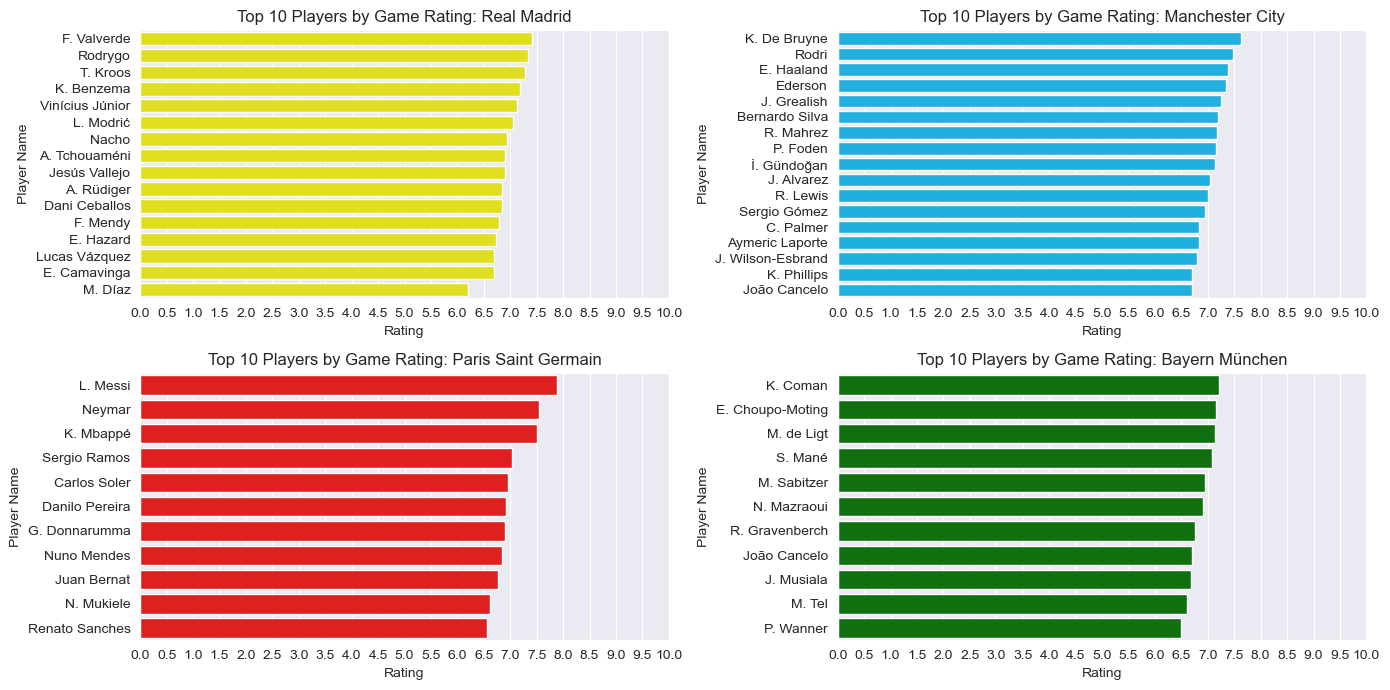

In [76]:
fig = plt.figure(figsize=(14, 7))
for i, team in enumerate(FOOTBALL_TEAMS, start=1):
    fg = fig.add_subplot(2, 2, i)
    # getting every player from a team then we sort by rating descending
    top_players = df_teams[team][["Name", "Games_Rating"]].sort_values(by="Games_Rating", ascending=False)
    sns.barplot(x="Games_Rating", y="Name", data=top_players, color=FOOTBALL_TEAMS_COLORS[team])
    # limit x-axis so it only has up until rating 10.0
    fg.set_xlim(right=10)
    # setting x-axis ticks for better precision
    fg.set_xticks([i / 10 for i in range(0, 101, 5)])
    plt.title(f"Top 10 Players by Game Rating: {team}")
    plt.xlabel("Rating")
    plt.ylabel("Player Name")

# fix the spacing between plots
fig.tight_layout()
plt.show()

We can see that every team has very good players, most of them medium players, and some bad ones.

---

### Top 20 Players by Rating (overall)

We create Top 20 players by rating for all team players together. The information gain is significant because we know which are the key players overall. 

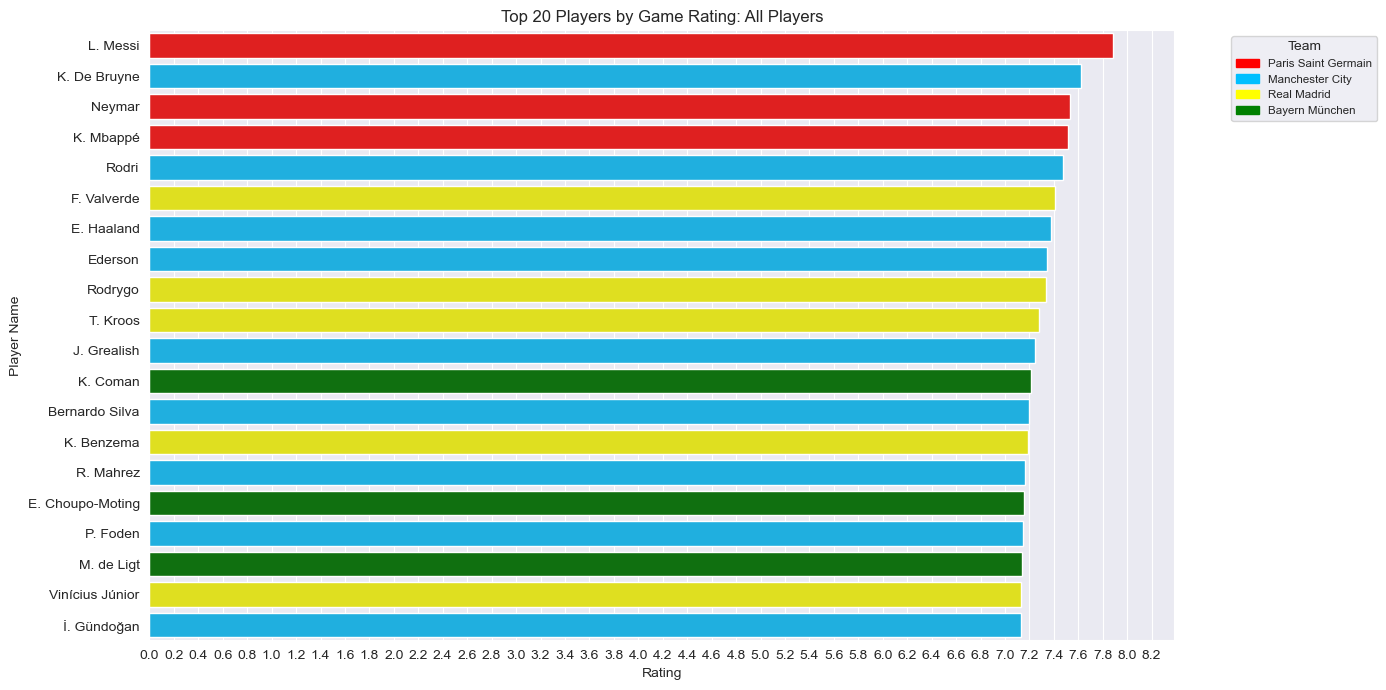

In [77]:
# get information need from the dataframe with all the players in it
all_players_name_rating = df_all_players[["Name", "Games_Rating", "Team"]]
fig = plt.figure(figsize=(14, 7))
# sort by rating descending and get only the first 20
top_players = all_players_name_rating.sort_values(by="Games_Rating", ascending=False).head(20)
# set every player with his team color
player_colors = [FOOTBALL_TEAMS_COLORS[team] for team in top_players["Team"]]
sns.barplot(x="Games_Rating", y="Name", data=top_players, palette=player_colors, legend=False, hue="Name")

# filter so we have unique labels for the legend
unique_teams = top_players["Team"].unique()
# set the color and the label for that team
legend_patches = [mpatches.Patch(color=FOOTBALL_TEAMS_COLORS[team], label=team) for team in unique_teams]
# add the legend to the plot
plt.legend(handles=legend_patches, title="Team", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# find the max rating and add an offset to it
max_rating = top_players["Games_Rating"].max() + 0.5
# limit x-axis so it only has until the max rating which includes the offset
plt.xlim(right=max_rating)
# add x-axis ticks for better precision
plt.xticks([i / 10 for i in range(0, int(max_rating*10), 2)])
plt.title(f"Top 20 Players by Game Rating: All Players")
plt.xlabel("Rating")
plt.ylabel("Player Name")

# fix the spacing between plots
fig.tight_layout()
plt.show()

We can see that Paris Saint Germain has dominated the top, but we can also see that Manchester City has the most players in top 20 

---

### BMI vs Rating (on team)

We create BMI vs Rating for every team. The information gain is significant because we know how much effect does BMI have over the player's rating. 

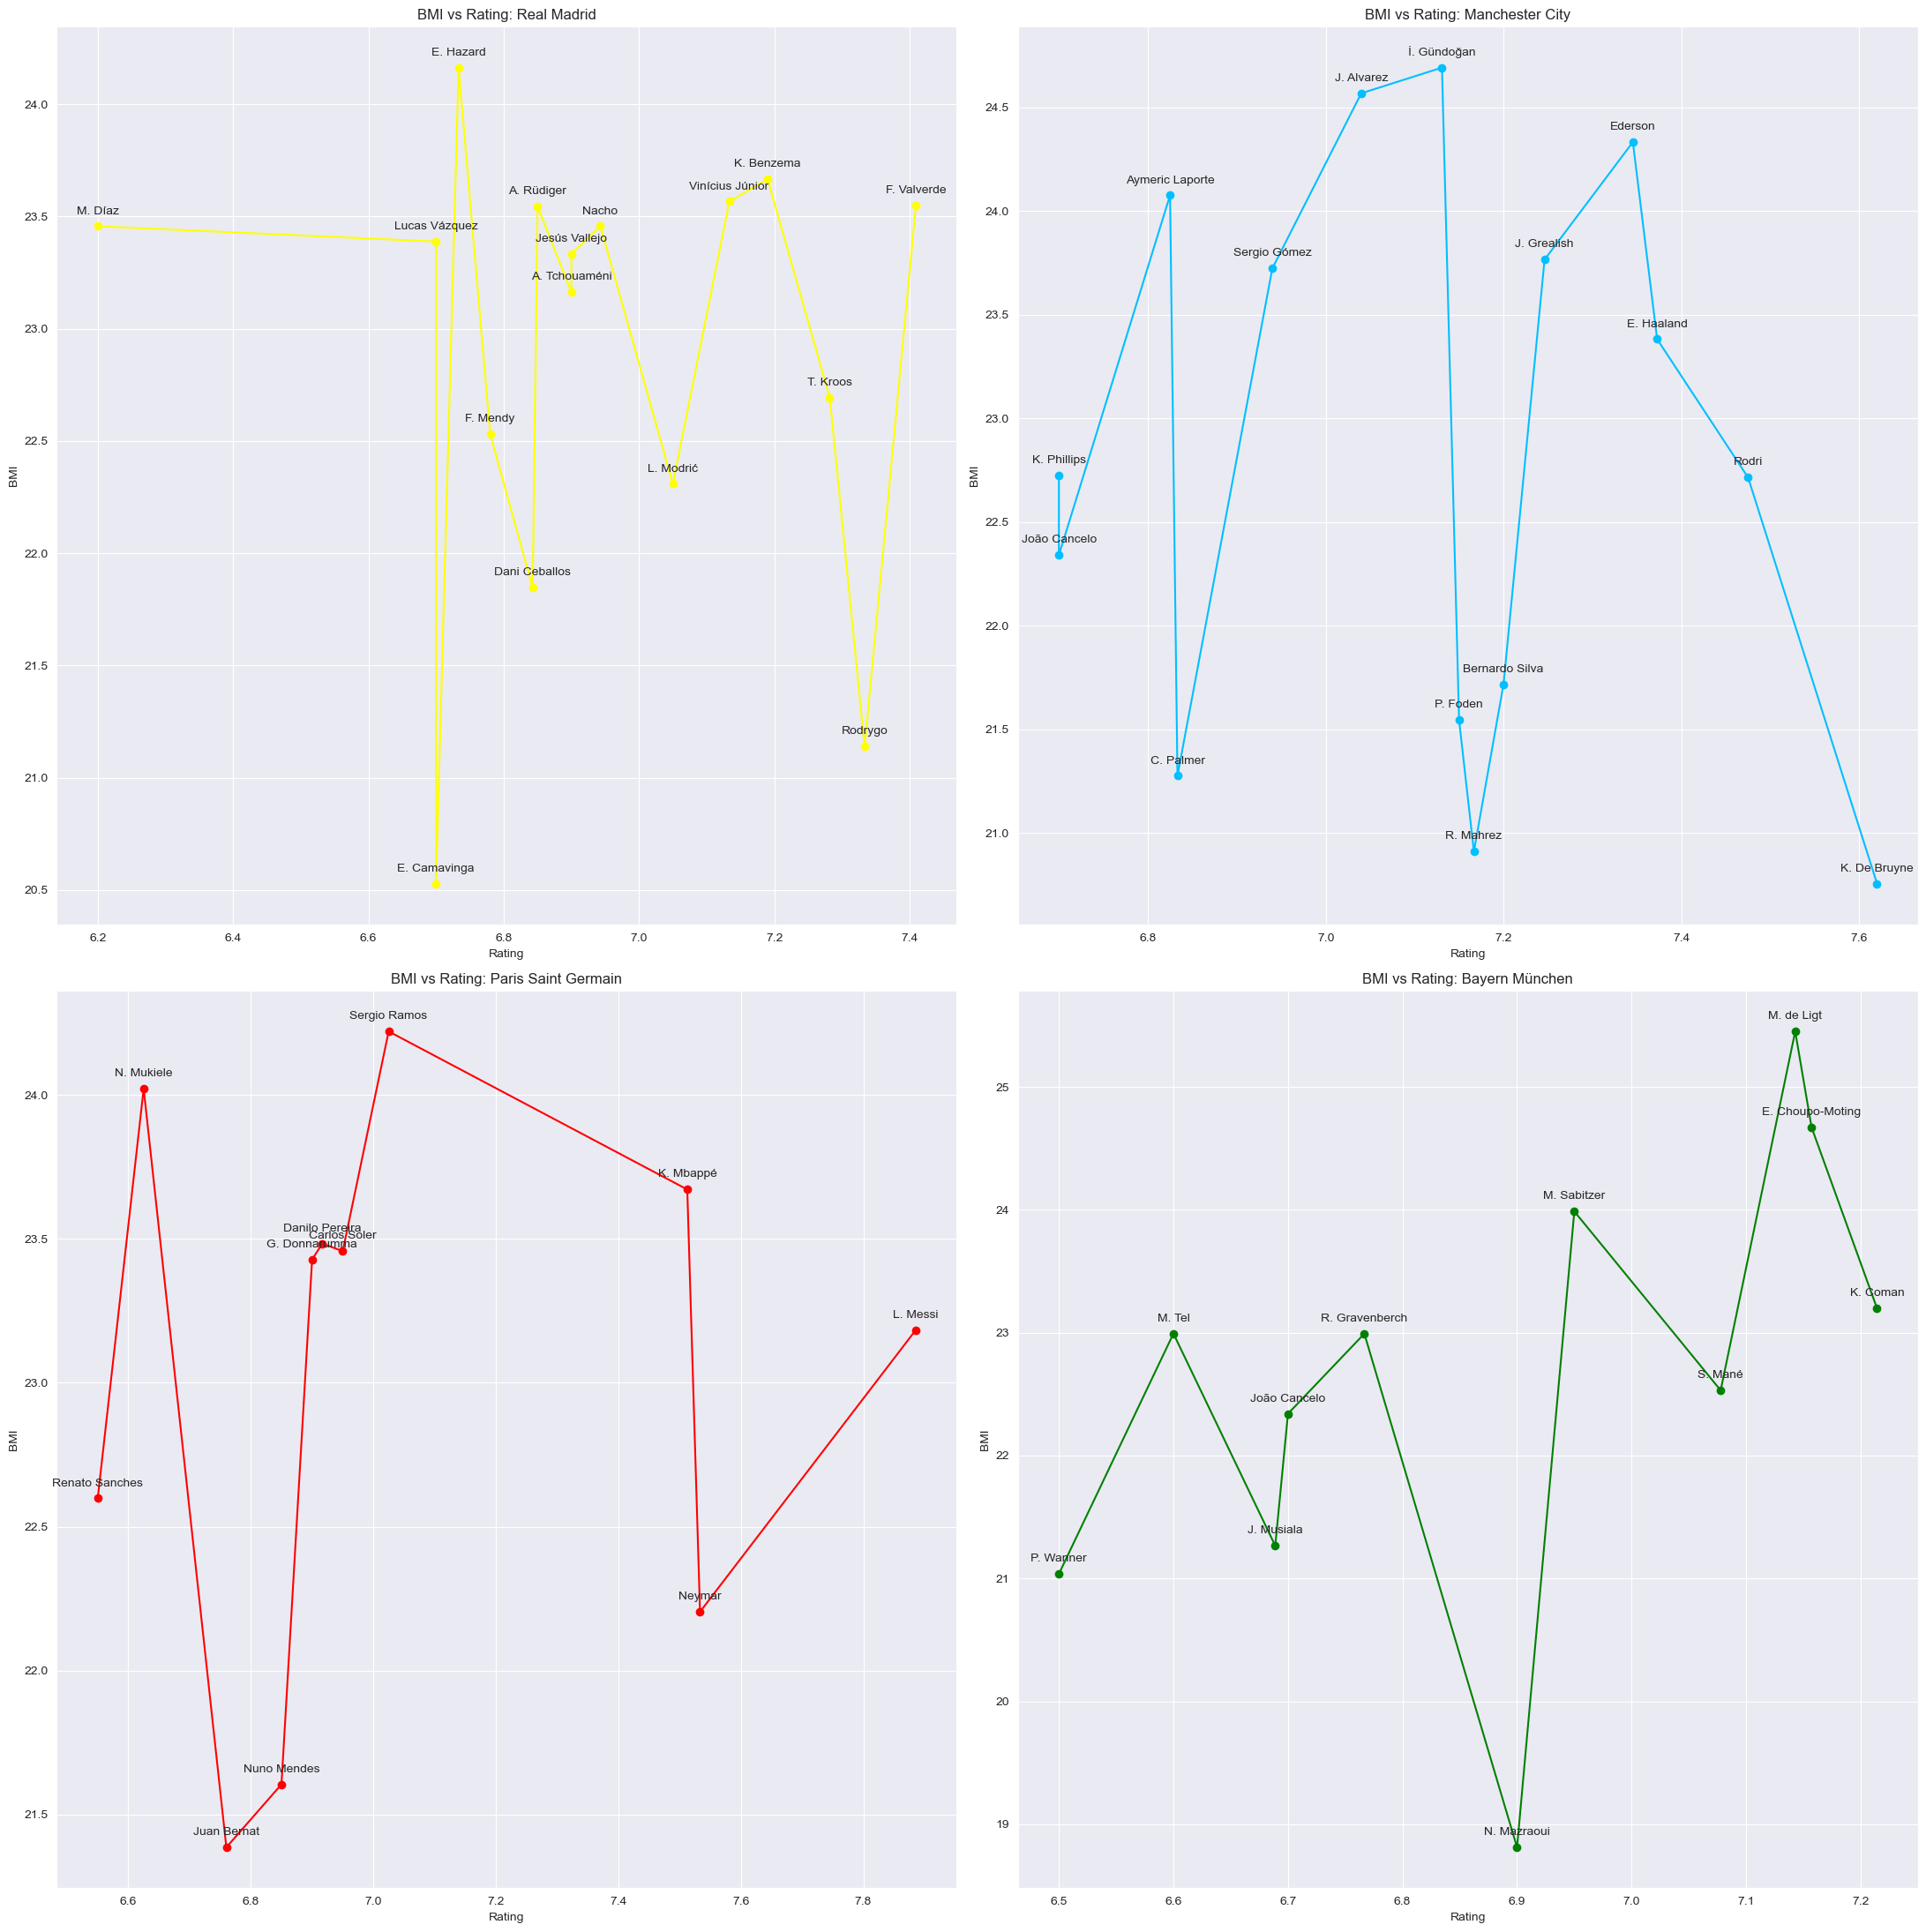

In [78]:
fig = plt.figure(figsize=(22,22))
for i, team in enumerate(FOOTBALL_TEAMS, start=1):
    # filter so we only have the specified categories and making a copy without the index
    df_bmi_rating = df_teams[team][["Name", "Games_Rating", "Weight_kg", "Height_cm"]].copy().reset_index()
    # calculate BMI with formula weight(kg) / height(m)^2
    df_bmi_rating["BMI"] = df_bmi_rating["Weight_kg"] / (df_bmi_rating["Height_cm"] / 100) ** 2
    # filter the ones that don't have a BMI
    df_bmi_rating = df_bmi_rating[df_bmi_rating["BMI"] > 0]
    # sort by rating
    df_bmi_rating.sort_values(by="Games_Rating", ascending=True, inplace=True)
    fg = fig.add_subplot(2, 2, i)
    fg.plot(df_bmi_rating["Games_Rating"], df_bmi_rating["BMI"], marker="o", linestyle="-", color=FOOTBALL_TEAMS_COLORS[team])
    for _, row in df_bmi_rating.iterrows():
        # give every point on the graph a name
        fg.annotate(row["Name"], (row["Games_Rating"], row["BMI"]), textcoords="offset points", xytext=(0, 10), ha="center")
    fg.set_title(f"BMI vs Rating: {team}")
    fg.set_xlabel("Rating")
    fg.set_ylabel("BMI")
    
# fix the spacing between plots
fig.tight_layout()

We can see that most players with high rating have a _BMI_ between 23 and 25, the exception is K. De Bruyne which seems funny because he is a top player, but also has one of the lowest _BMI_ (under 21). We can also see that Paris Saint Germain as a team with very good players, has a very calibrated _BMI_. Another thing that captures my interest is that most of the players have a decent _BMI_, as expected.

---

### Top 15 Players BMI vs Rating (overall)

We create BMI vs Rating for all team players together. The information gain is significant because we know how much effect does BMI have over the player's rating. 

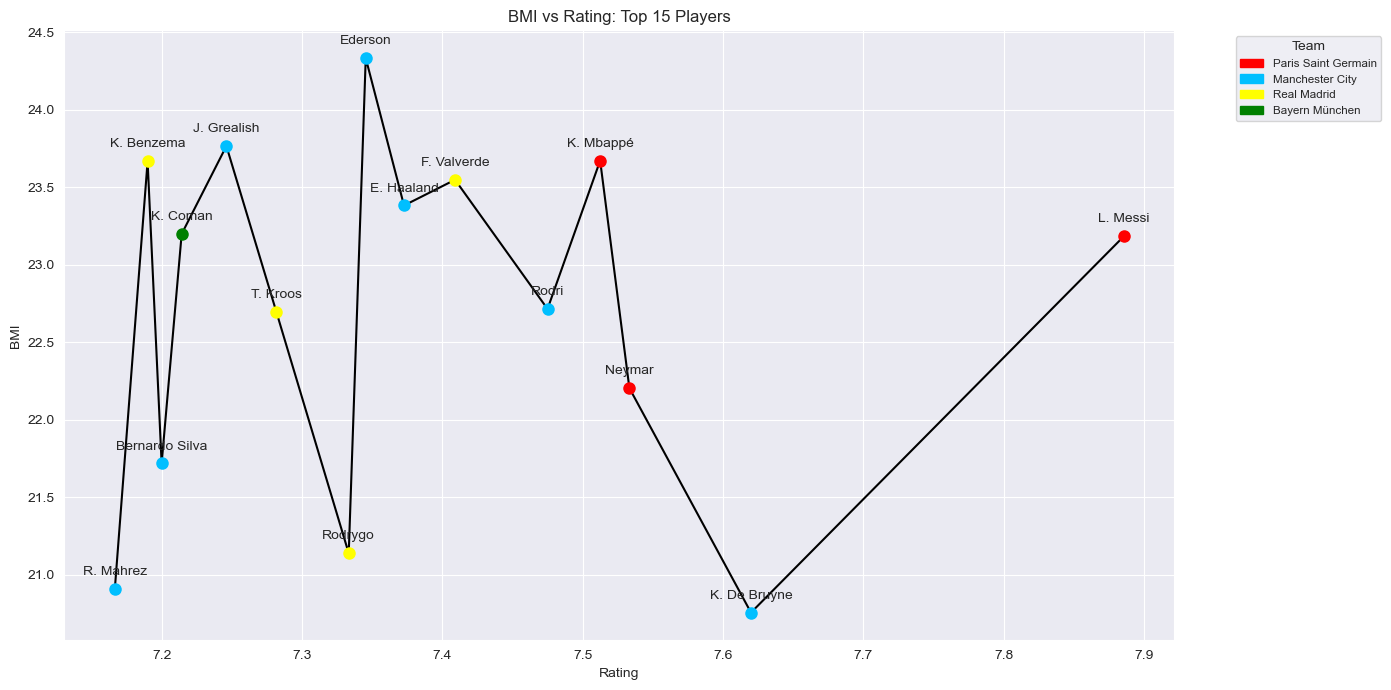

In [79]:
fig = plt.figure(figsize=(14,7))
# filter so we only have the specified categories and making a copy without the index
df_bmi_rating = df_all_players[["Name", "Games_Rating", "Weight_kg", "Height_cm", "Team"]].copy().reset_index()
# calculate BMI with formula weight(kg) / height(m)^2
df_bmi_rating["BMI"] = df_bmi_rating["Weight_kg"] / (df_bmi_rating["Height_cm"] / 100) ** 2
# filter the ones that don't have a BMI
df_bmi_rating = df_bmi_rating[df_bmi_rating["BMI"] > 0]
# sort by rating
df_bmi_rating.sort_values(by="Games_Rating", ascending=False, inplace=True)
# get only the first 15
df_bmi_rating = df_bmi_rating.head(15)
fg = fig.add_subplot(1, 1, 1)
# add the line
fg.plot(df_bmi_rating["Games_Rating"], df_bmi_rating["BMI"], marker="o", linestyle="-", color="black")
for _, row in df_bmi_rating.iterrows():
    # add every point with its color
    fg.plot(row["Games_Rating"], row["BMI"], marker="o", color=FOOTBALL_TEAMS_COLORS[row["Team"]], markersize=8)
    # add the name to every point
    fg.annotate(row["Name"], (row["Games_Rating"], row["BMI"]), textcoords="offset points", xytext=(0, 10), ha="center")
# filter so we have unique labels for the legend
unique_teams = top_players["Team"].unique()
# set the color and the label for that team
legend_patches = [mpatches.Patch(color=FOOTBALL_TEAMS_COLORS[team], label=team) for team in unique_teams]
# Add the legend to the plot
plt.legend(handles=legend_patches, title="Team", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

fg.set_title(f"BMI vs Rating: Top 15 Players")
fg.set_xlabel("Rating")
fg.set_ylabel("BMI")

# fix the spacing between plots
fig.tight_layout()

Now that we can see the data clearer, we can correct the statement written before and say that most of the good players have a _BMI_ between 22 and 24, maybe it's a sign... or only coincidence (not really).

---

### Cards Received by Player (on team)

We create Cards Received by Player for every team. The information gain is significant because we know which player is the most aggressive and who to watch out for.

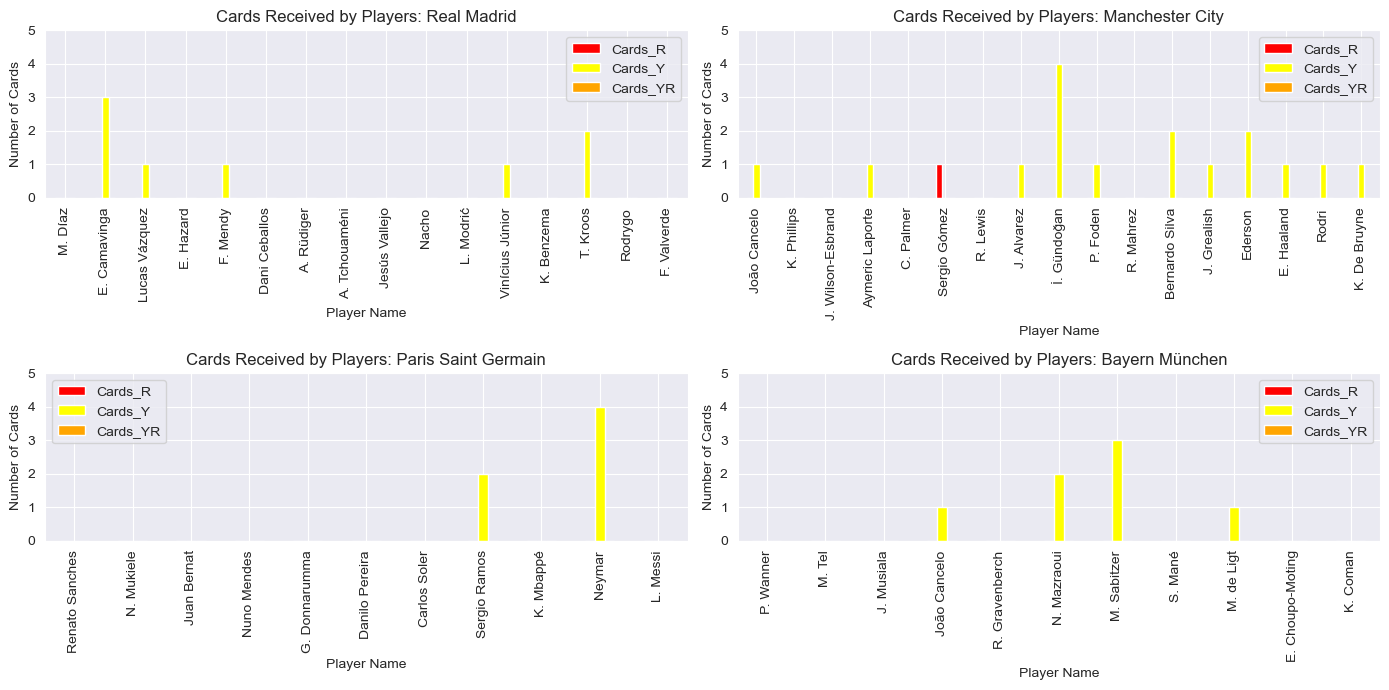

In [80]:
fig = plt.figure(figsize=(14,7))
# get the max out of all types of cards with respect to all the players overall and add an offset
max_cards = max(list(df_all_players[["Cards_Y", "Cards_R", "Cards_YR"]].max())) + 1
for i, team in enumerate(FOOTBALL_TEAMS, start=1):
    # make a copy for the dataframe team which contains the information needed
    df_duels_done = df_teams[team][["Name", "Cards_R", "Cards_Y", "Cards_YR", "Games_Rating"]].copy()
    axc = fig.add_subplot(2, 2, i)
    # get every player's cards and sort them by their rating
    df_duels_done.groupby("Name").sum().sort_values(by="Games_Rating")[["Cards_R", "Cards_Y", "Cards_YR"]].plot.bar(ax=axc, color=["red", "yellow", "orange"])
    axc.set_xlabel("Player Name")
    axc.set_ylabel("Number of Cards")
    axc.set_title(f"Cards Received by Players: {team}")
    
    # rotate player names if needed to prevent overlapping
    plt.xticks(rotation=90, ha="center")
    # limit y-axis so it only has until the max cards which includes the offset
    plt.ylim(top=max_cards)
# fix the spacing between plots
fig.tight_layout()

As we can clearly see from the plots, Manchester City has the most players that received a yellow card, also the player with the most yellow cards, and the only player with a red card. Paris Saint Germain the fewest players that received a yellow card. We can deduct that Manchester City is taking advantage of their cards taken by player, and maybe that their tackles are not the best...

---

### Cards Received by All Players (on team)

We create Cards Received by Player for all players on a team. The information gain is significant because we know which is the team with the most aggressive play style.

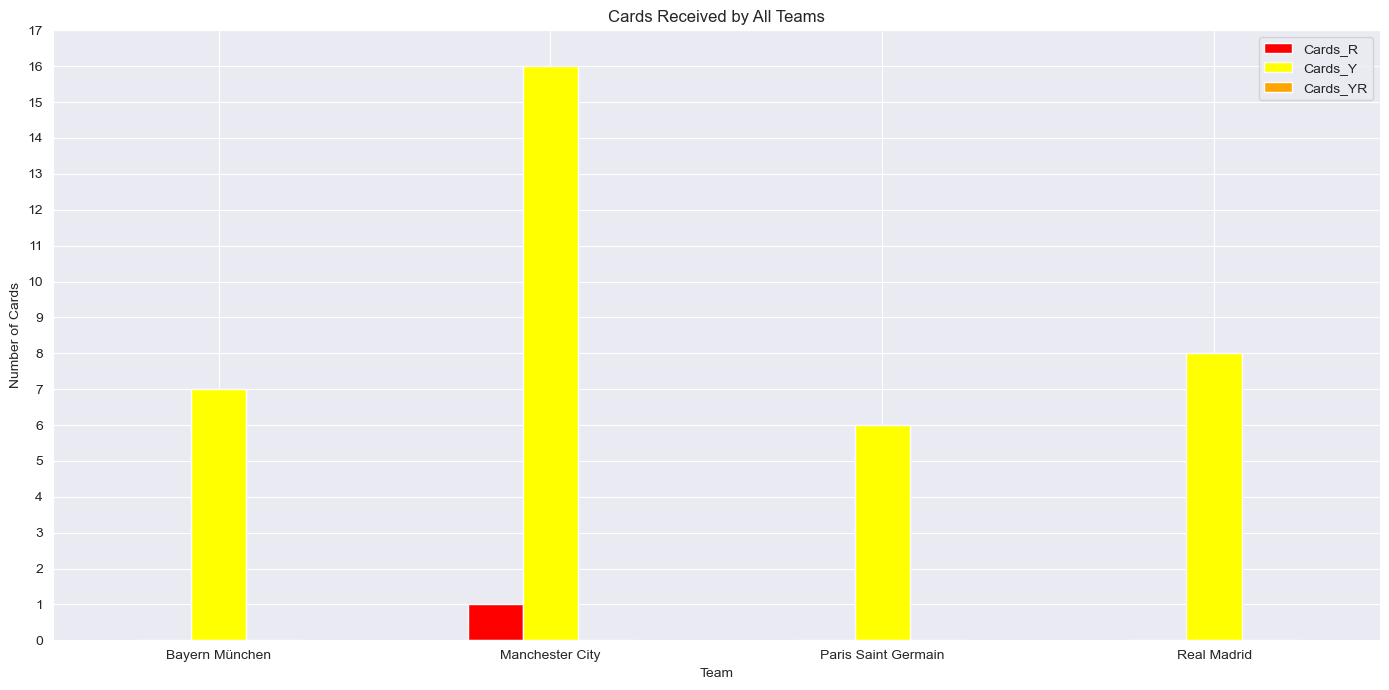

In [81]:
# group the information needed by team and add the numeric values
all_duels_by_team = df_all_players[["Team", "Cards_R", "Cards_Y", "Cards_YR"]].groupby("Team").sum()
fig = plt.figure(figsize=(14,7))
# get the max out of all types of cards with respect to all cards received by a team and add an offset
max_cards = max(list(all_duels_by_team[["Cards_R", "Cards_Y", "Cards_YR"]].max())) + 1
fg = fig.add_subplot(1, 1, 1)
all_duels_by_team.plot.bar(ax=fg, color=["red", "yellow", "orange"])
fg.set_xlabel("Team")
fg.set_ylabel("Number of Cards")
fg.set_title(f"Cards Received by All Teams")
plt.xticks(rotation=0, ha="center")
# setting y-axis ticks for better precision
plt.yticks([i for i in range(0, max_cards + 1)])
# limit y-axis so it only has until the max cards which includes the offset
plt.ylim(top=max_cards)
fig.tight_layout()

Now we can clearly see that Manchester is way up there with the most yellow cards overall and the only one to receive a red card, but we can also see that the other teams are pretty near each other with respect to their yellow cards received. One thing that I haven't mentioned before is that no team has players that received a yellow card twice in the same game so every one of them is cautious after their first yellow card, except the one that received a red card :).

---

### Dribbles Done by Player (on team)

We create Dribbles Done by Player for every team. The information gain is significant because we know which player is the most skillful at dribbling so that we can concentrate the defense on his side of the field. Another scope can be to see which player has too many unsuccessful attempts at dribbling and maybe do less or exercise more.

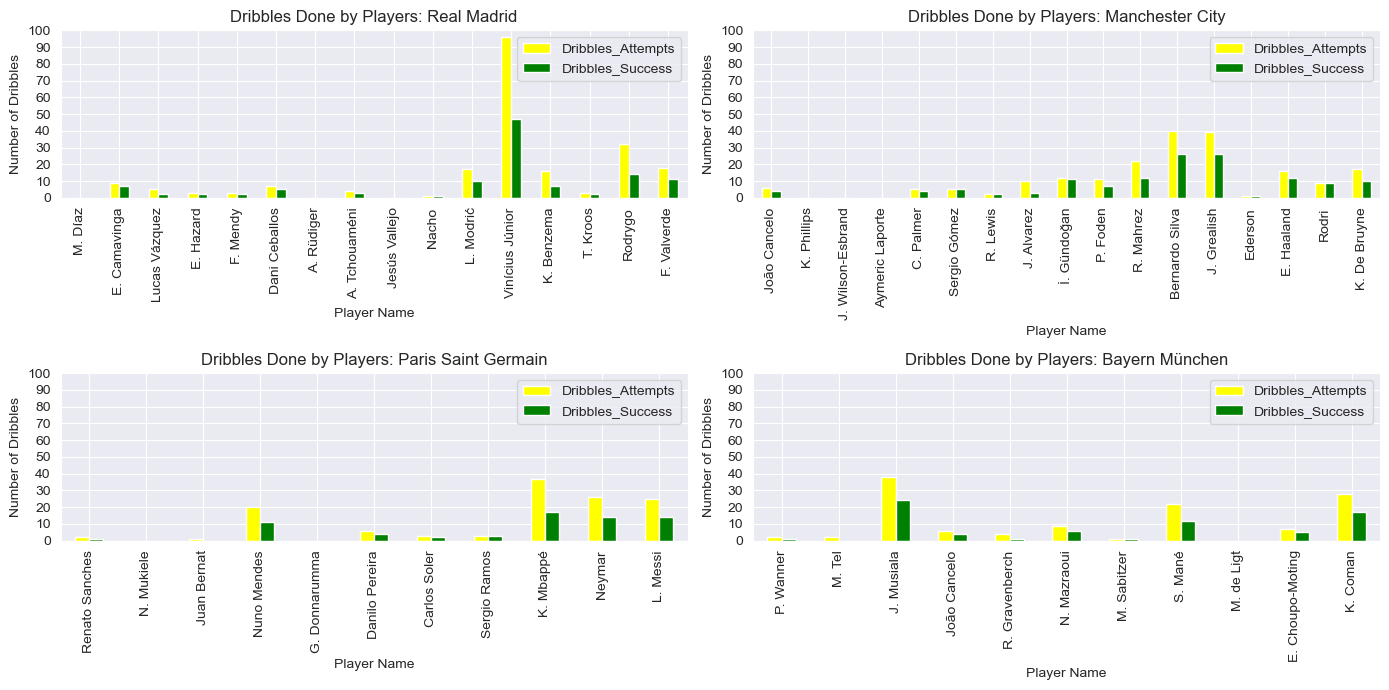

In [82]:
fig = plt.figure(figsize=(14,7))
# get the max dribbles attempt
max_dribbling = df_all_players["Dribbles_Attempts"].max()
for i, team in enumerate(FOOTBALL_TEAMS, start=1):
    # get a dataframe copy with the information needed
    df_duels_done = df_teams[team][["Name", "Dribbles_Attempts", "Dribbles_Success", "Games_Rating"]].copy()
    axc = fig.add_subplot(2, 2, i)
    # group everything by name and sort the rating
    df_duels_done.groupby("Name").sum().sort_values(by="Games_Rating")[["Dribbles_Attempts", "Dribbles_Success"]].plot.bar(ax=axc, color=["yellow", "green"])
    axc.set_xlabel("Player Name")
    axc.set_ylabel("Number of Dribbles")
    axc.set_title(f"Dribbles Done by Players: {team}")

    # Rotate player names if needed to prevent overlapping
    plt.xticks(rotation=90, ha="center")
    # limit y-axis so it only has until the max dribbling which includes the offset
    plt.ylim(top=max_dribbling)
    # setting y-axis ticks for better precision and add an offset
    plt.yticks([i for i in range(0, max_dribbling + int(max_dribbling * 0.1), 10)])
# fix the spacing between plots
fig.tight_layout()

Right from the beginning we can tell who is the most skillful dribbler, but also the one that has been trying the most (Vinícius Júnior). Then, we can see that Manchester City has the most player that are dibbling.

---

### Dribbles Done by All Players (on team)

We create Dribbles Done by All Players for all players on a team. The information gain is significant because we know which is the team with the most skillful players or which does the most dribble mistakes.

In [83]:
# get the information needed group by team and sum the numeric values
all_duels_by_team = df_all_players[["Team", "Dribbles_Attempts", "Dribbles_Success"]].groupby("Team").sum()
fig = plt.figure(figsize=(14,7))
# get the max dribbles
max_dribbles = max(list(all_duels_by_team[["Dribbles_Attempts", "Dribbles_Success"]].max()))
# add an offset to it
max_dribbles = max_dribbles + int(max_dribbles * 0.1)
fg = fig.add_subplot(1, 1, 1)
all_duels_by_team.plot.bar(ax=fg, color=["yellow", "green"])
fg.set_xlabel("Team")
fg.set_ylabel("Number of Dribbles")
fg.set_title(f"Dribbles Done by All Teams")
plt.xticks(rotation=0, ha="center")
# set y-axis ticks for better precision
plt.yticks([i for i in range(0, max_dribbles, 10)])
# set y-axis limit
plt.ylim(top=max_dribbles)
fig.tight_layout()

We can clearly see that Manchester City has the most successful dribble attempts, despite Real Madrid having Vinícius Júnior which has over twice as many dribbling attempts/success compared to any of Bayern's players.

---

### Duels Done by Player (on team)

We create Duels Done by Player for every team. The information gain is significant because we know which player is the most skillful at duels so that we can concentrate the offense on the ones that are not taking so many duels or not winning many of them.

In [84]:
fig = plt.figure(figsize=(14,13))
# get the total duels max
max_duels = df_all_players["Duels_Total"].max()
for i, team in enumerate(FOOTBALL_TEAMS, start=1):
    # create a dataframe copy with the information needed
    df_duels_done = df_teams[team][["Name", "Duels_Total", "Duels_Won", "Games_Rating"]].copy()
    axc = fig.add_subplot(2, 2, i)
    # group dataframe by name, sum the numeric values and sort by rating
    df_duels_done.groupby("Name").sum().sort_values(by="Games_Rating")[["Duels_Total", "Duels_Won"]].plot.bar(ax=axc, color=["blue", "green"])
    axc.set_xlabel("Player Name")
    axc.set_ylabel("Number of Duels")
    axc.set_title(f"Duels Done by Players: {team}")

    # rotate player names if needed to prevent overlapping
    plt.xticks(rotation=90, ha="center")
    # set y-axis limit
    plt.ylim(top=max_duels)
    # set y-axis ticks for better precision
    plt.yticks([i for i in range(0, max_duels + int(max_duels * 0.1), 10)])
# fix the spacing between plots
fig.tight_layout()

As expected, because of it's high dribbling attempts, Vinícius Júnior has the most duels and also the most duels won. We can also see that Manchester City has a very solid players who engage in duels. By seeing this data, we can tell many things about the player, such as, does he like to engage in duels or pass it to its teammate, or does this player need to be targeted more because of its lack/abundance of duels...

---

### Duels Done by All Players (on team)

We create Duels Done by All Players for all players on a team. The information gain is significant because we know which is the team with the most duels taken or which team doesn't win many duels.

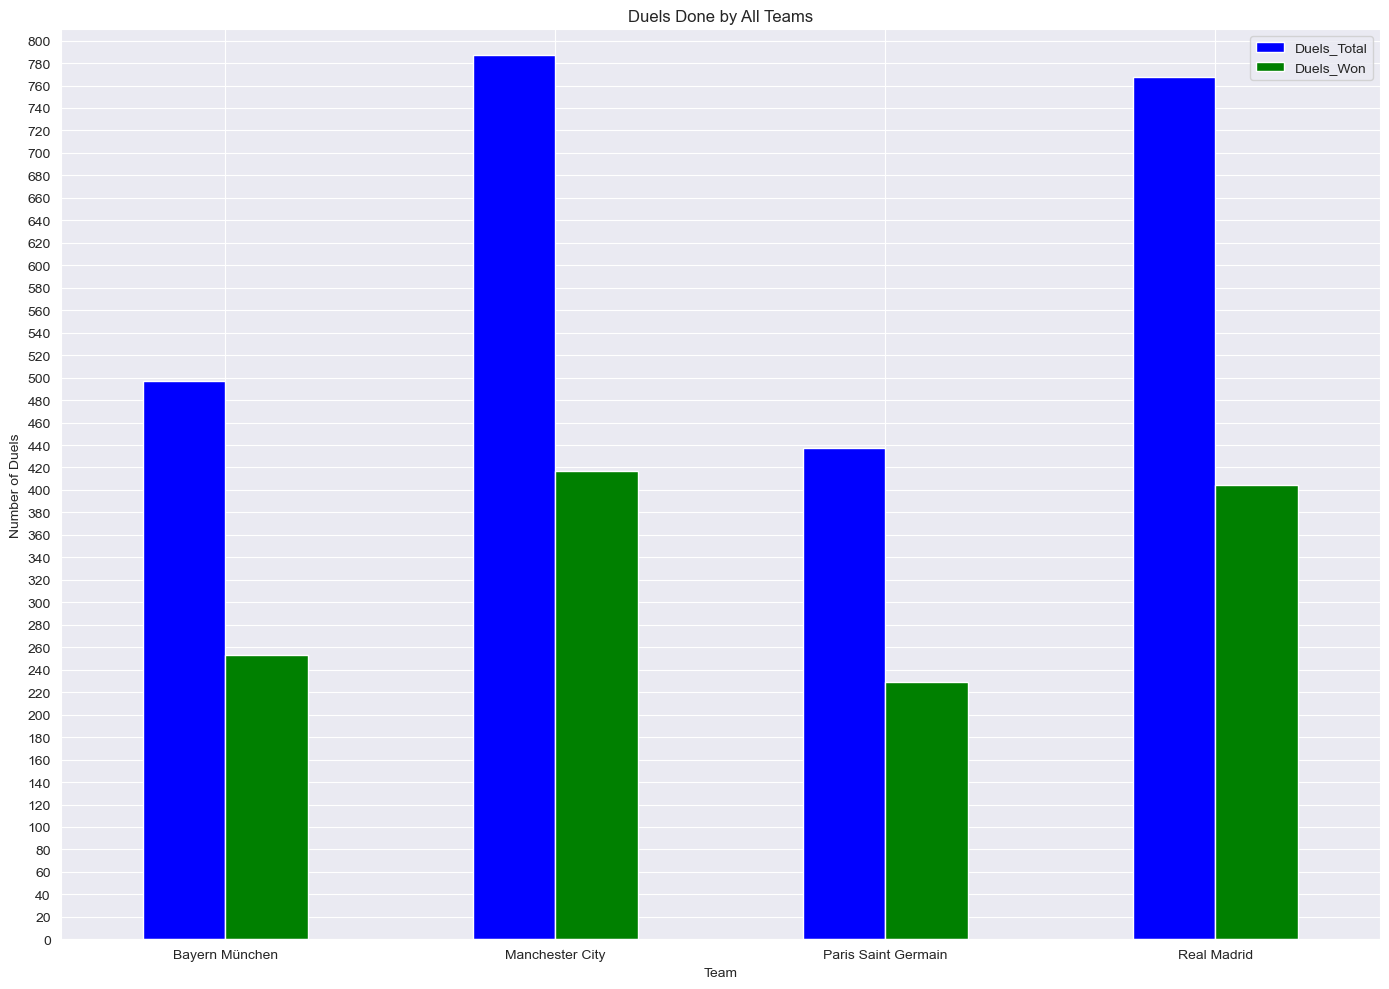

In [85]:
# get the information needed grouped by team and sum the numeric values
all_duels_by_team = df_all_players[["Team", "Duels_Total", "Duels_Won"]].groupby("Team").sum()
fig = plt.figure(figsize=(14,10))
# get the max duels overall
max_duels = max(list(all_duels_by_team[["Duels_Total", "Duels_Won"]].max()))
# add an offset to it
max_duels = max_duels + int(max_duels * 0.03)
fg = fig.add_subplot(1, 1, 1)
all_duels_by_team.plot.bar(ax=fg, color=["blue", "green"])
fg.set_xlabel("Team")
fg.set_ylabel("Number of Duels")
fg.set_title(f"Duels Done by All Teams")
plt.xticks(rotation=0, ha="center")
# set y-axis ticks for better precision
plt.yticks([i for i in range(0, max_duels, 20)])
# set y-axis limit
plt.ylim(top=max_duels)
# fix the spacing between plots
fig.tight_layout()

Now we can see clearer that Real Madrid is very similar in play style with Manchester City, and the other 2 similar between them. We can tell that the one with high duels aren't afraid to take one, but the other ones have more of a passive style.

---

### Fouls by Player (on team)

We create Fouls by Player for every team. The information gain is significant because we know which player can draw fouls and which commits the most fouls.

In [94]:
fig = plt.figure(figsize=(14,10))
# get the max fouls overall and add an offset
max_fouls = max(list(df_all_players[["Fouls_Commited", "Fouls_Drawn"]].max())) + 1
for i, team in enumerate(FOOTBALL_TEAMS, start=1):
    # make a team dataframe copy with the information needed
    df_duels_done = df_teams[team][["Name", "Fouls_Commited", "Fouls_Drawn", "Games_Rating"]].copy()
    axc = fig.add_subplot(2, 2, i)
    # group the data by name, sum the numeric values and sort it by rating
    df_duels_done.groupby("Name").sum().sort_values(by="Games_Rating")[["Fouls_Commited", "Fouls_Drawn"]].plot.bar(ax=axc, color=["red", "cornflowerblue"])
    axc.set_xlabel("Player Name")
    axc.set_ylabel("Number of Fouls")
    axc.set_title(f"Fouls by Players: {team}")

    # Rotate player names if needed to prevent overlapping
    plt.xticks(rotation=90, ha="center")
    # set y-axis ticks for better precision
    plt.yticks([i for i in range(0, max_fouls, 2)])
    # set y-axis limit
    plt.ylim(top=max_fouls)
# fix the spacing between plots
fig.tight_layout()

From these graphs we can gather that J. Grealish has the most fouls drawn, so we can say that is a very dangerous player to defend around when his inside the penalty area. Bernardo Silva being one of the most weak player in the defending side because he commits too many fouls, making him a liability. Also, we can tell how tactical are Paris Saint Germain players, because they have commited only a few fouls. 

---

### Fouls by All Players (on team)

We create Fouls by All Players for all players on a team. The information gain is significant because we know which is the team can draw fouls and which commits the most fouls.

In [87]:
# get the information needed and group it by team and sum the numeric values
all_fouls_by_team = df_all_players[["Team", "Fouls_Commited", "Fouls_Drawn"]].groupby("Team").sum()
fig = plt.figure(figsize=(14,7))
# get the max fouls by team 
max_fouls = max(list(all_fouls_by_team[["Fouls_Commited", "Fouls_Drawn"]].max()))
# add an offset to it
max_fouls = max_fouls + int(max_fouls * 0.1)
fg = fig.add_subplot(1, 1, 1)
all_fouls_by_team.plot.bar(ax=fg, color=["red", "cornflowerblue"])
fg.set_xlabel("Team")
fg.set_ylabel("Number of Fouls")
fg.set_title(f"Fouls by All Teams")
plt.xticks(rotation=0, ha="center")
# set y-axis ticks for better precision
plt.yticks([i for i in range(0, max_fouls, 5)])
# set y-axis limit
plt.ylim(top=max_fouls)
# fix the spacing between plots
fig.tight_layout()

Now that we can see all the player together, we can tell that Bayern is a 50/50 team, Real Madrid and Manchester City have a very similar play style, but Real Madrid is more careful with the fouls commited and Paris Saint Germain as said before is very tactical with their fouls, over 2 times as many fouls drawn, than commited.

---

### Minutes/Game vs Rating (on team)

We create Minutes/Game vs Rating for every team. The information gain is significant because we know which player has played the most with regards to his rating.

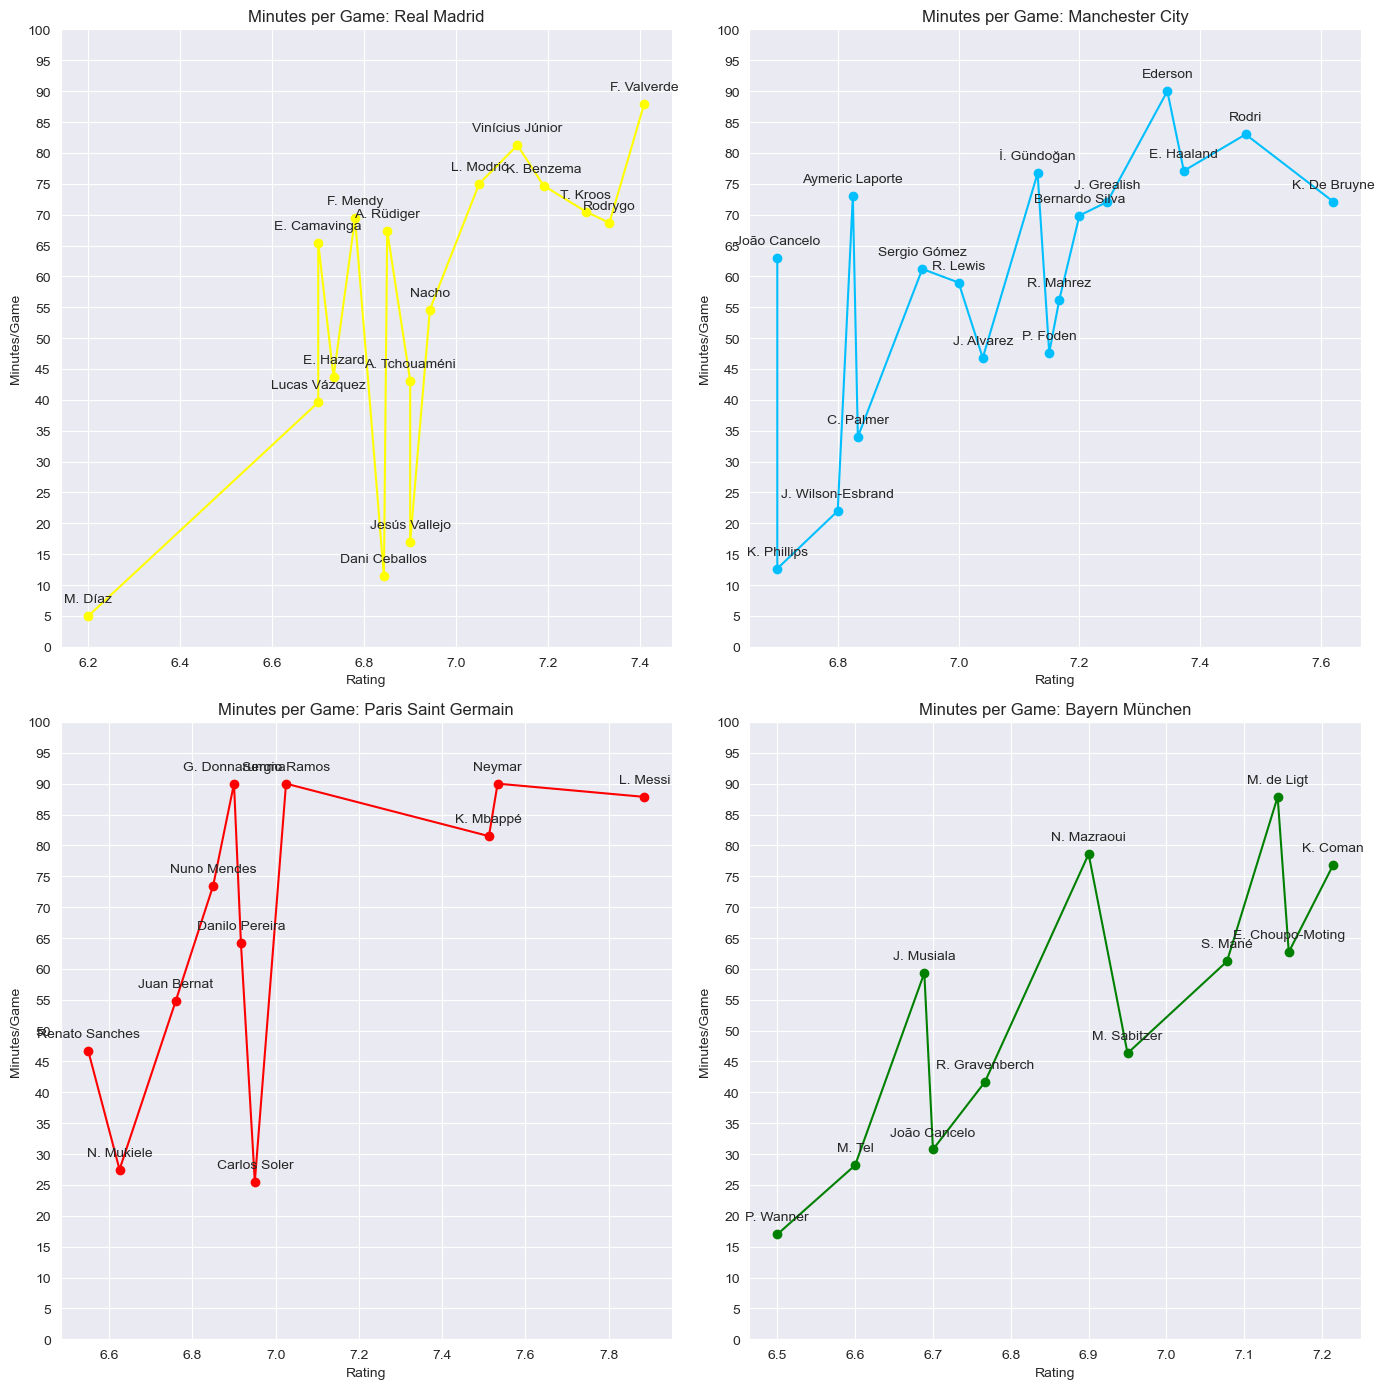

In [88]:
fig = plt.figure(figsize=(14,14))
for i, team in enumerate(FOOTBALL_TEAMS, start=1):
    # make a team dataframe copy with the information needed and reset the index
    df_minutes_per_game = df_teams[team][["Name", "Games_Rating", "Games_Appearences", "Games_Minutes"]].copy().reset_index()
    # calculate the minutes per game with the formulate minutes / no appearences
    df_minutes_per_game["Minutes/Game"] = df_minutes_per_game["Games_Minutes"] / df_minutes_per_game["Games_Appearences"]
    # filter so we only have players that played in at least 1 game
    df_minutes_per_game = df_minutes_per_game[df_minutes_per_game["Minutes/Game"] > 0]
    # sort the data by rating
    df_minutes_per_game.sort_values(by="Games_Rating", ascending=True, inplace=True)
    fg = fig.add_subplot(2, 2, i)
    fg.plot(df_minutes_per_game["Games_Rating"], df_minutes_per_game["Minutes/Game"], marker="o", linestyle="-", color=FOOTBALL_TEAMS_COLORS[team])
    for _, row in df_minutes_per_game.iterrows():
        # give every dot its player name
        fg.annotate(row["Name"], (row["Games_Rating"], row["Minutes/Game"]), textcoords="offset points", xytext=(0, 10), ha="center")
    fg.set_title(f"Minutes per Game: {team}")
    fg.set_xlabel("Rating")
    fg.set_ylabel("Minutes/Game")
    plt.xticks(rotation=0, ha="center")
    # set y-axis ticks for better precision
    plt.yticks([i for i in range(0, 101, 5)])
    # set y-axis limit
    plt.ylim(top=100)

# fix the spacing between plots
fig.tight_layout()

From the graphs presented above we can see that player rating has an impact on the minutes he plays per game, but there are some exceptions such as: E. Camavinga, F. Mendy, A. Rüdiger, João Cancelo, Aymeric Laporte, G. Donnarumma; which are some pretty low rated player, but get to play a good part of the game if not all of it.

---

### Top 15 Minutes/Game vs Rating (overall)

We create Minutes/Game vs Rating for Top 15 Players (by time played per game) for all the player. The information gain is significant because we know which player has played the most and the effect of its rating on play time per game.

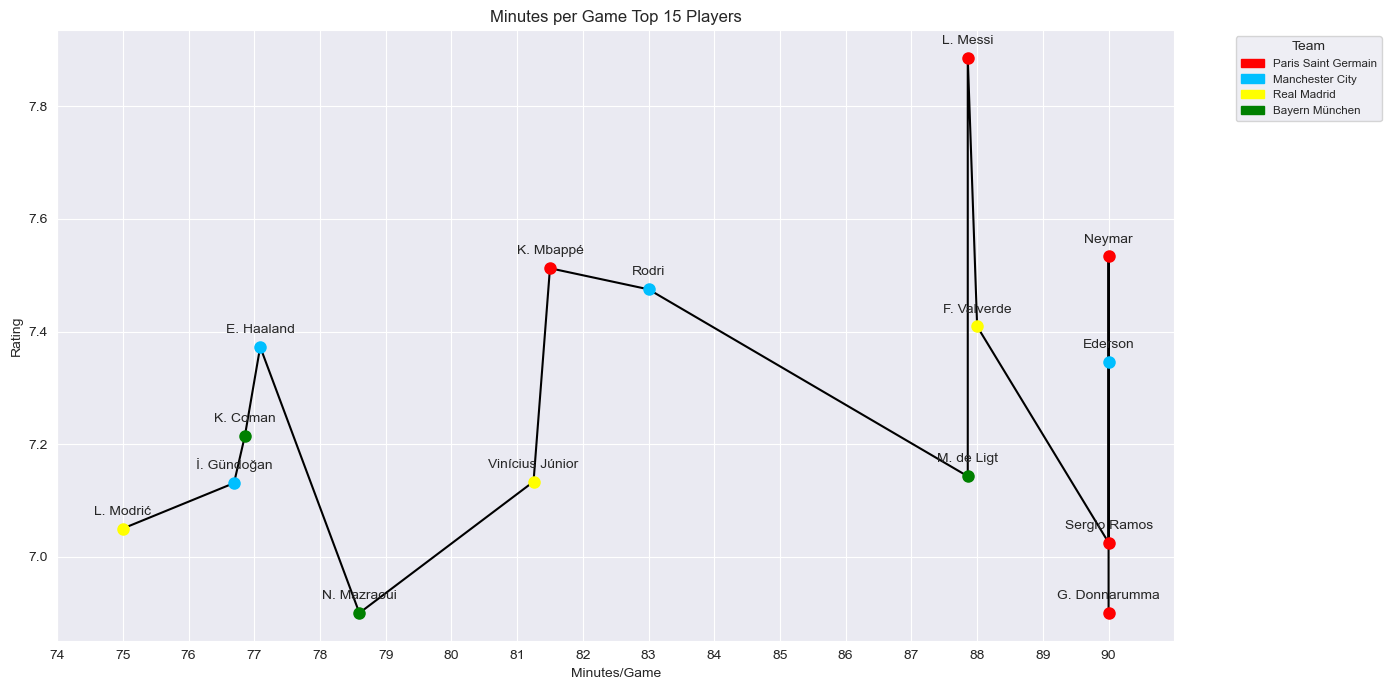

In [89]:
fig = plt.figure(figsize=(14,7))
# make a dataframe copy with all information needed and reset the index
all_minutes_per_game = df_all_players[["Name", "Games_Rating", "Games_Appearences", "Games_Minutes", "Team"]].copy().reset_index()
# calculate the minutes per game with the formulate minutes / no appearences
all_minutes_per_game["Minutes/Game"] = all_minutes_per_game["Games_Minutes"] / all_minutes_per_game["Games_Appearences"]
# filter so we only have players that played in at least 1 game
all_minutes_per_game = all_minutes_per_game[all_minutes_per_game["Minutes/Game"] > 0]
# sort by time played per game
all_minutes_per_game.sort_values(by="Minutes/Game", ascending=False, inplace=True)
# get the first 15 players
all_minutes_per_game = all_minutes_per_game.head(15)
fg = fig.add_subplot(1, 1, 1)
fg.plot(all_minutes_per_game["Minutes/Game"], all_minutes_per_game["Games_Rating"], marker="o", linestyle="-", color="black")
for _, row in all_minutes_per_game.iterrows():
    # make each player dot the color of its team
    fg.plot(row["Minutes/Game"], row["Games_Rating"], marker="o", color=FOOTBALL_TEAMS_COLORS[row["Team"]], markersize=8)
    # give every dot a name
    fg.annotate(row["Name"], (row["Minutes/Game"], row["Games_Rating"]), textcoords="offset points", xytext=(0, 10), ha="center")

# filter so we have unique labels for the legend
unique_teams = top_players["Team"].unique()
# set the color and the label for that team
legend_patches = [mpatches.Patch(color=FOOTBALL_TEAMS_COLORS[team], label=team) for team in unique_teams]
# Add the legend to the plot
plt.legend(handles=legend_patches, title="Team", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

fg.set_title(f"Minutes per Game Top 15 Players")
fg.set_xlabel("Minutes/Game")
fg.set_ylabel("Rating")
# get min minutes of time player per game and add an offset
min_minutes_per_game = int(all_minutes_per_game[["Minutes/Game"]].min()["Minutes/Game"]) - 1
# get max minutes of time player per game and add an offset
max_minutes_per_game = int(all_minutes_per_game[["Minutes/Game"]].max()["Minutes/Game"]) + 1
# set x-axis ticks for better precision
plt.xticks([i for i in range(min_minutes_per_game, max_minutes_per_game)])
# set x-axis limits
plt.xlim(left=min_minutes_per_game, right=max_minutes_per_game)

# fix the spacing between plots
fig.tight_layout()

Now we can see better, and we can tell that almost all players which are in the top players for the minutes per game category, are rated over 7.0 and even over 7.2. We can also see that Paris Saint Germain has "a lot" of main player that they always let to play.

---

### Players' Country Origin (overall)

We create Players' Country Origin for all the players. The information gain is significant because we know which country is the best to go and scout for new players that will maybe end up to be great.


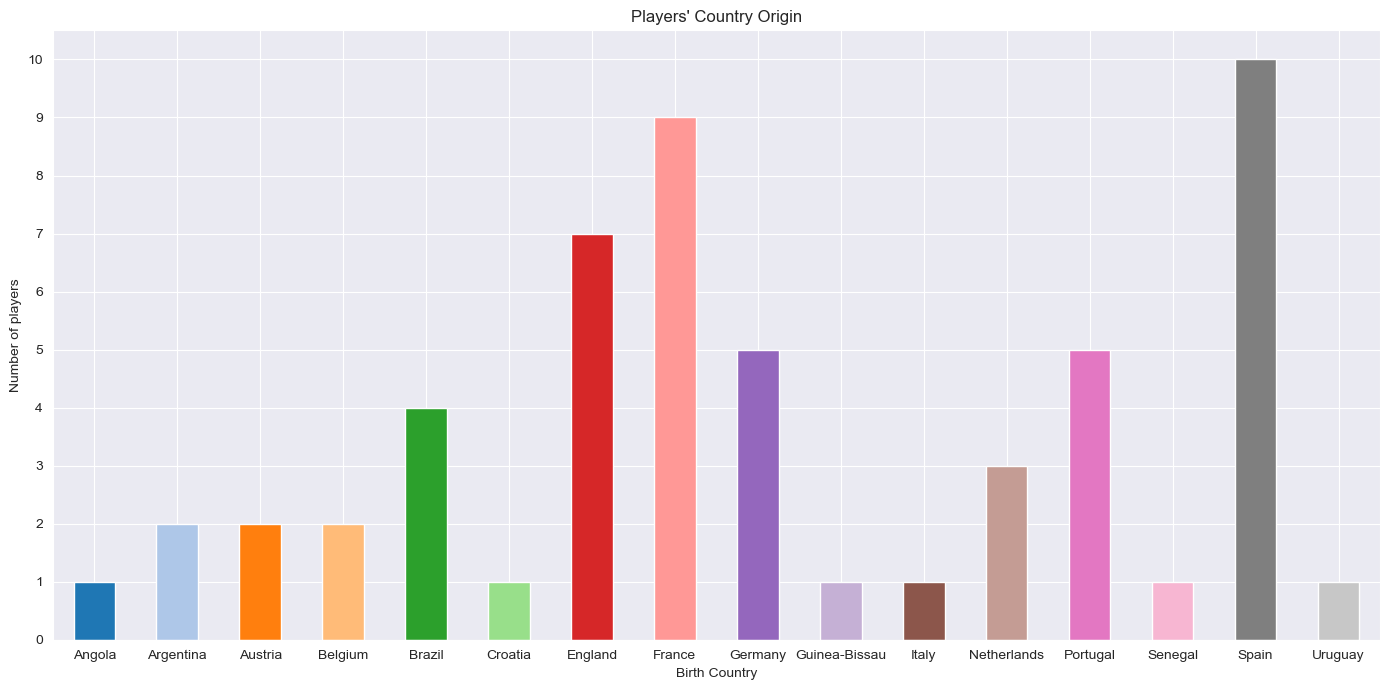

In [90]:
all_birth_country = df_all_players[["Birth_Country"]].groupby("Birth_Country").value_counts()
max_births = all_birth_country.max()
fig = plt.figure(figsize=(14,7))
fg = fig.add_subplot(1, 1, 1)
colors = cm.tab20(range(len(all_birth_country)))
all_birth_country.plot.bar(ax=fg, color=colors)
fg.set_xlabel("Birth Country")
fg.set_ylabel("Number of players")
fg.set_title(f"Players' Country Origin")
plt.xticks(rotation=0, ha="center")
plt.yticks([i for i in range(0, max_births + 1)])
fig.tight_layout()

 From this graph we can see that most of the players come from countries that are known for their football skills, but it also helps us see where should the scouts for players got to for finding new talents. 

---

### Conclusions

In this assignment we looked at the analysis of football players statistics from different team which competed in UEFA Champions League in season 2022. We focused more on the difference between the players of a team stats and the players from all the teams combined stats, but also the effect that BMI has on a player's rating and the country origin of all the players from these teams. We got some good insights about the teams, and it could be used for tactics purpose, such as:

- if a team is good with dribbles the other team should use a formation with more defence
- if a team is very aggressive, then the other players should be careful with the individuals that are known to be aggressive
- if a player didn't get to play as much as he should, then the coach would watch over he's play time

I didn't really have any problems with the API, the only part that I had "trouble" was when saving some values from the API that should've been integers, they were saved as float, but converted them Data Verification.

There are more to be done with these datas, such as:
- the players' pass information by team and overall
- the players' penalty information by team and overall
- the players' shots information by team and overall
- the players' tackles information by team and overall
- the players' stats information, all together (pass, shots, tackles etc.) by team and overall